### Задание 1: Измените функцию calc_logloss так, чтобы нули по возможности не попадали в np.log.

In [300]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from matplotlib.colors import ListedColormap

In [301]:
def calc_logloss(y, y_pred):
    y = y[np.nonzero(y_pred)]
    y_pred = y_pred[np.nonzero(y_pred)]
    err = - np.mean(y * np.log(y_pred) + (1.0 - y) * np.log(1.0 - y_pred))
    return err

In [302]:
# тестируем пример
y1 = np.array([1, 0, 0, 0, 1, 0, 1])
y_pred1 = np.array([0.9, 0, 0.3, 0.4, 0.8, 0, 0.9])
calc_logloss(y1, y_pred1)

0.2602730300669171

### Задание 2: Подберите аргументы функции eval_model для логистической регрессии таким образом, чтобы log loss был минимальным.

In [303]:
def sigmoid(z):
    res = 1 / (1 + np.exp(-z))
    return res

In [304]:
def eval_model(X, y, iterations, alpha=1e-4):
    np.random.seed(42)
    w = np.random.randn(X.shape[1])
    n = X.shape[1]
    err_history = []
    for i in range(1, iterations+1):
        y_pred = sigmoid(np.dot(w, X.T))
        err = calc_logloss(y, y_pred)
        if i > 2 and np.abs(err - err_history[-1]) < 1e-5:
            return w, i-1, np.array(err_history)
        err_history.append(err)
        R = y_pred - y
        w -= alpha * (1/n * np.dot((y_pred - y), X))        
    return w, i, np.array(err_history)

In [305]:
# Генерируем данные для тестов
classes = datasets.make_classification(n_samples=100, n_features=2, n_informative=2,
                                       n_redundant=0, n_classes=2, random_state=1)

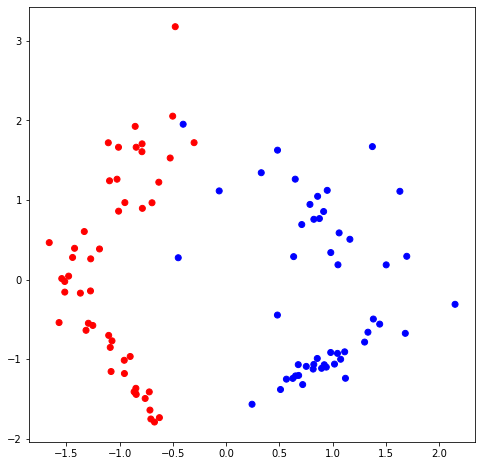

In [306]:
colors = ListedColormap(['red', 'blue'])

plt.figure(figsize=(8, 8))
plt.scatter([x[0] for x in classes[0]], [x[1] for x in classes[0]], c=classes[1], cmap=colors)

In [307]:
X = classes[0]
y = classes[1]

In [308]:
def calc_std_feat(x):
    res = (x - x.mean()) / x.std()
    return res

In [309]:
iterations = 30000

In [310]:
alphas = [1/(10**i) for i in range(6, 0, -1)]
min_errs = []
itrs = []
for alpha in alphas:
    W, iters, err_history = eval_model(X, y, iterations=iterations, alpha=alpha)
    itrs.append(iters)
    min_errs.append(err_history.min())

In [311]:
result = min(zip(min_errs, itrs, alphas))

In [312]:
print(f"Оптимальные значения: iterations - {result[1]}, alpha - {result[2]}")
print(f"Получено минимальное значение log loss: {result[0]}")

Оптимальные значения: iterations - 96, alpha - 0.1
Получено минимальное значение log loss: 0.06988812537913794


In [313]:
iterations = result[1]
alpha = result[2]

### Задание 3: Создайте функцию calc_pred_proba, возвращающую предсказанную вероятность класса 1 (на вход подаются W, который уже посчитан функцией eval_model и X, на выходе - массив y_pred_proba).

In [314]:
W, _, _ = eval_model(X, y, iterations=iterations, alpha=alpha)

In [315]:
def calc_pred_proba(W, X):
    z = np.dot(W, X.T)
    y_pred_proba = sigmoid(z)    
    return y_pred_proba

In [316]:
W

array([5.96429694, 0.45039813])

In [317]:
y_pred_proba = calc_pred_proba(W, X)

### Задание 4: Создайте функцию calc_pred, возвращающую предсказанный класс (на вход подаются W, который уже посчитан функцией eval_model и X, на выходе - массив y_pred).

In [318]:
def calc_pred(w, X):
    y_pred = []
    z = np.dot(W, X.T)
    A = sigmoid(z)
    
    # За порог отнесения к тому или иному классу примем вероятность 0.5
    for i in range(len(A)):
        if (A[i] > 0.5): 
            y_pred.append(1)
        elif (A[i] <= 0.5):
            y_pred.append(0)
    
    return y_pred

In [319]:
y_pred = calc_pred(W, X)

### Задание 5: Посчитайте Accuracy, матрицу ошибок, точность и полноту, а также F1 score.

In [320]:
accuracy = 1 / len(y) * np.sum(y_pred == y)
accuracy

0.98

In [321]:
# матрица ошибок
import pandas as pd

y_pred_m = np.array(y_pred)

TP = np.sum(y_pred_m[np.nonzero(y_pred_m)] == y[np.nonzero(y_pred_m)])
FP = np.sum(y_pred_m[np.nonzero(y_pred_m)] != y[np.nonzero(y_pred_m)])
FN = np.sum(y_pred_m[np.flatnonzero(y_pred_m == 0)] != y[np.flatnonzero(y_pred_m == 0)])
TN = np.sum(y_pred_m[np.flatnonzero(y_pred_m == 0)] == y[np.flatnonzero(y_pred_m == 0)])

data = [
    [TP, FP],
    [FN, TN]
]
df = pd.DataFrame(data=data, index=["a(x)=+1", "a(x)=-1"], columns=["y=+1", "y=-1"])
df

,y=+1,y=-1
a(x)=+1,48,0
a(x)=-1,2,50


In [322]:
# точность
precision = TP / (TP + FP)
precision

1.0

In [323]:
# полнота
recall = TP / (TP + FN)
recall

0.96

In [324]:
# F1 score
F = 2 * precision * recall / (precision + recall)
F

0.9795918367346939

### Задание 6: Могла ли модель переобучиться? Почему?

Модель могла переобучиться, т.к. некоторые признаки могут быть линейно зависимыми